In the following I want to write the DataLoader

# Libraries and Pathes

In [2]:
# Libraries
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset
from pathlib import Path
from PIL import Image
import numpy as np
import glob
import torchvision.transforms.v2 as v2
from typing import Optional, Tuple, Dict, List


In [3]:

# HPC Terrabyte
# adapt the user to your needs
# USER = "di38gaz"
# # keep the following unchanged
# ROOT = Path("/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022")
# USER_PATH = ROOT / f"users/{USER}"
# DATA_PATH = ROOT / "data"

# when you are on a local dev client
# uncomment these lines and make necessary ajdustments
ROOT = Path(r"C:\Users\elena\Documents\04-geo-oma\data\xview2-subset") 
PNG_PATH = ROOT / "png_images"
TARGET_PATH = ROOT / 'targets'



In [4]:
pre_png = Image.open("C:/Users/elena/Documents/04-geo-oma/data/xview2-subset/png_images/hurricane-florence_00000096_pre_disaster.png")
pre_mask = Image.open("C:/Users/elena/Documents/04-geo-oma/data/xview2-subset/targets/hurricane-florence_00000096_pre_disaster.png")

In [5]:
pre_png.mode


'RGB'

# Dataset Class

In [6]:

# # Definiere explizite Funktionen anstelle von Lambda-Ausdrücken
# # TODO - Kontrollieren


# def transform():
#     return v2.Compose([
#         v2.RandomHorizontalFlip(),
#         v2.RandomVerticalFlip(),
#         v2.RandomRotation(degrees=15),
#         v2.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),

#         v2.ToDtype(torch.float32, scale=True)

#     ])

# def image_transform():
    
#     v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Farbanpassung
#     v2.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),  # Weichzeichnung
#     v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    

#         # Photometrische Augmentierungen (nur für Bilder!)
#         #v2.Lambda(color_jitter),
#         #v2.Lambda(gaussian_blur),

#         # Normalisierung für die RGB-Bilder (nicht für Masken!)
#         #v2.Lambda(normalize)


In [7]:

# def transform() -> v2.Compose:
#     return v2.Compose([
#         # Geometrische Augmentierungen (gleich auf Bilder & Masken)
#         v2.RandomHorizontalFlip(),
#         v2.RandomVerticalFlip(),
#         v2.RandomRotation(degrees=15),
#         v2.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),

#         # **Photometrische Augmentierungen (nur für Bilder!)**
#         v2.Lambda(lambda x: torch.cat([v2.ColorJitter(0.2, 0.2, 0.2)(x[:3]), x[3:]], dim=0)),
#         v2.Lambda(lambda x: torch.cat([v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))(x[:3]), x[3:]], dim=0)),

#         # Normalisierung für die RGB-Bilder (nicht für Masken!)
#         v2.Lambda(lambda x: torch.cat([
#             v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(x[:3]),
#             x[3:]
#         ], dim=0))
#     ])

In [8]:
def transform():
    """Transform für Bilder & Masken"""
    return v2.Compose([
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),
        v2.RandomRotation(degrees=15),
        v2.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
        v2.ToDtype(torch.float32, scale=True)  # Automatische Skalierung auf [0,1]
    ])

def image_transform():
    """Nur für RGB-Bilder"""
    return v2.Compose([
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        v2.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

class xView2Dataset(Dataset):

    def __init__(self,
                 png_path: str,
                 target_path: str,
                 transform: callable = None,
                 image_transform: callable = None):
        
        self.png_path = png_path
        self.target_path = target_path
        self.transform = transform
        self.image_transform = image_transform
        

        # get all pre-disaster images:
        self.pre_images = sorted(self.png_path.glob("*_pre_disaster.png"))
        
        self.pairs = [] #

        for pre_img_path in self.pre_images:
            post_img_path = self.png_path / pre_img_path.name.replace("_pre_disaster", "_post_disaster")

            post_target_path = self.target_path / pre_img_path.name.replace("_pre_disaster", "_post_disaster")
            pre_target_path = pre_target_path = self.target_path / pre_img_path.name


            if post_img_path.exists() and post_target_path.exists() and pre_target_path.exists():
                self.pairs.append((pre_img_path, post_img_path, pre_target_path, post_target_path))

        assert len(self.pairs) > 0, "No matching image-pairs found!"

        # super().__init__()

    def __len__(self):
        return len(self.pre_images)

    def __getitem__(self, index):
        pre_img_path, post_img_path, pre_target_path, post_target_path = self.pairs[index]

        # load images and target masks with 
        
        pre_img = Image.open(pre_img_path).convert("RGB")
        post_img = Image.open(post_img_path).convert("RGB")
        pre_target_mask = Image.open(pre_target_path).convert('L')
        post_target_mask = Image.open(post_target_path).convert('L')

        # convert to numpy arrays
        pre_img = np.array(pre_img, dtype=np.float32) / 255.0
        post_img = np.array(post_img, dtype=np.float32) / 255.0
        pre_target_mask = np.array(pre_target_mask, dtype=np.float32)
        post_target_mask = np.array(post_target_mask, dtype=np.float32)

        # convert to Tensor
        pre_img = torch.tensor(pre_img).permute(2, 0, 1)  # (H, W, C) → (C, H, W)
        post_img = torch.tensor(post_img).permute(2, 0, 1)
        pre_target_mask = torch.tensor(pre_target_mask).unsqueeze(0)  # (H, W) → (1, H, W)
        post_target_mask = torch.tensor(post_target_mask).unsqueeze(0)

    # Transformation (optional)


        if self.transform:
            stack = torch.cat([pre_img, post_img, pre_target_mask, post_target_mask], dim=0)  # (8, H, W)
            stack = self.transform(stack)

            pre_img, post_img, pre_target_mask, post_target_mask = stack[:3], stack[3:6], stack[6:7], stack[7:8]
        
        if self.image_transform:
            
            # Nur auf Bilder Normalisierung anwenden
            pre_img = self.image_transform(pre_img)
            post_img = self.image_transform(post_img)

        return pre_img, post_img, pre_target_mask, post_target_mask 
    

    
        
        

Der Code unten wurde von chatgpt als verbesserung angefühtr - er klappt aber nciht

In [9]:
# import torch
# import torchvision.transforms.v2 as v2
# from torch.utils.data import Dataset
# from PIL import Image
# import numpy as np
# from pathlib import Path

# def transform():
#     """Transform für Bilder & Masken"""
#     return v2.Compose([
#         v2.RandomHorizontalFlip(),
#         v2.RandomVerticalFlip(),
#         v2.RandomRotation(degrees=15),
#         v2.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
#         v2.ToDtype(torch.float32, scale=True)  # Automatische Skalierung auf [0,1]
#     ])

# def image_transform():
#     """Nur für RGB-Bilder"""
#     return v2.Compose([
#         v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#         v2.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
#         v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ])

# class xView2Dataset(Dataset):
#     def __init__(self, png_path: str, target_path: str, transform=None, image_transform=None):
#         self.png_path = Path(png_path)
#         self.target_path = Path(target_path)
#         self.transform = transform
#         self.image_transform = image_transform

#         # Finde alle Pre-Disaster-Bilder
#         self.pre_images = sorted(self.png_path.glob("*_pre_disaster.png"))
        
#         self.pairs = []
#         for pre_img_path in self.pre_images:
#             post_img_path = self.png_path / pre_img_path.name.replace("_pre_disaster", "_post_disaster")
#             pre_target_path = self.target_path / pre_img_path.name
#             post_target_path = self.target_path / pre_img_path.name.replace("_pre_disaster", "_post_disaster")

#             if post_img_path.exists() and pre_target_path.exists() and post_target_path.exists():
#                 self.pairs.append((pre_img_path, post_img_path, pre_target_path, post_target_path))

#         assert len(self.pairs) > 0, "No matching image pairs found!"

#     def __len__(self):
#         return len(self.pairs)

#     def __getitem__(self, index):
#         pre_img_path, post_img_path, pre_target_path, post_target_path = self.pairs[index]

#         # Lade die Bilder
#         pre_img = Image.open(pre_img_path).convert("RGB")
#         post_img = Image.open(post_img_path).convert("RGB")
#         pre_mask = Image.open(pre_target_path).convert('L')
#         post_mask = Image.open(post_target_path).convert('L')

#         # Wandle in Tensors um (automatisch normalisiert auf [0,1])
#         pre_img = v2.ToTensor()(pre_img)
#         post_img = v2.ToTensor()(post_img)
#         pre_mask = v2.ToTensor()(pre_mask)
#         post_mask = v2.ToTensor()(post_mask)

#         # Transformation für Masken (keine Farbänderungen!)
#         if self.transform:
#             pre_mask = self.transform()(pre_mask)
#             post_mask = self.transform()(post_mask)

#         # Transformation nur für RGB-Bilder
#         if self.image_transform:
#             pre_img = self.image_transform()(pre_img)
#             post_img = self.image_transform()(post_img)

#         return pre_img, post_img, pre_mask, post_mask


## Plotting without transformations

In [10]:
xView2 = xView2Dataset(png_path = PNG_PATH,
                              target_path = TARGET_PATH
                              )


In [11]:
print(len(xView2.pairs))




20


In [12]:
pre_img,post_img,pre_target,post_target = xView2[5]

# Überprüfe die Dimensionen und die Datentypen der geladenen Tensors
print(f"Pre-Image shape: {pre_img.shape}, dtype: {pre_img.dtype}")
print(f"Post-Image shape: {post_img.shape}, dtype: {post_img.dtype}")
print(f"Pre-Mask shape: {pre_target.shape}, dtype: {pre_target.dtype}")
print(f"Post-Mask shape: {post_target.shape}, dtype: {post_target.dtype}")

Pre-Image shape: torch.Size([3, 1024, 1024]), dtype: torch.float32
Post-Image shape: torch.Size([3, 1024, 1024]), dtype: torch.float32
Pre-Mask shape: torch.Size([1, 1024, 1024]), dtype: torch.float32
Post-Mask shape: torch.Size([1, 1024, 1024]), dtype: torch.float32


Plot mit Pre und Post Bildern sowie masken

C:\Users\elena\AppData\Local\Temp\ipykernel_18828\3654242109.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  axes[1, 0].imshow(pre_mask_np, cmap=plt.cm.get_cmap('gray', 256))  # Pre-mask mit Graustufen
C:\Users\elena\AppData\Local\Temp\ipykernel_18828\3654242109.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


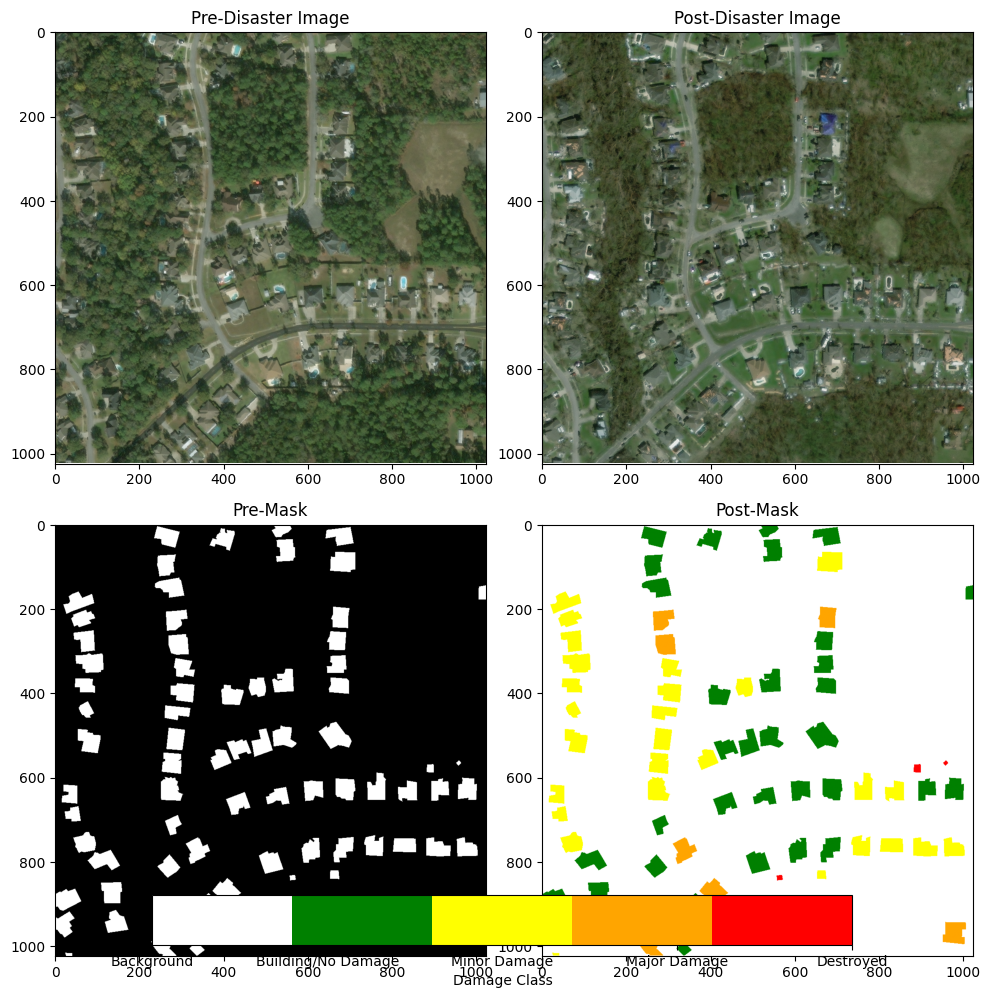

In [13]:
import matplotlib.pyplot as plt

# Konvertiere die Tensoren zurück zu NumPy-Arrays für die Anzeige
pre_img_np = pre_img.permute(1, 2, 0).numpy()  # (C, H, W) → (H, W, C)
post_img_np = post_img.permute(1, 2, 0).numpy()
pre_mask_np = pre_target.squeeze().numpy()  # (1, H, W) → (H, W)
post_mask_np = post_target.squeeze().numpy()

# Erstelle eine Liste der Farben für jede Klasse
colors = {
    0: 'white',       # Background
    1: 'green',       # No damage
    2: 'yellow',      # Minor damage
    3: 'orange',      # Major damage
    4: 'red'          # Destroyed
}

# Erstelle ein 2x2-Subplot für die Bilder
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Visualisiere die Bilder
axes[0, 0].imshow(pre_img_np)
axes[0, 0].set_title("Pre-Disaster Image")
axes[0, 1].imshow(post_img_np)
axes[0, 1].set_title("Post-Disaster Image")
axes[1, 0].imshow(pre_mask_np, cmap=plt.cm.get_cmap('gray', 256))  # Pre-mask mit Graustufen
axes[1, 0].set_title("Pre-Mask")
axes[1, 1].imshow(post_mask_np, cmap=plt.cm.colors.ListedColormap([colors[0], colors[1], colors[2], colors[3], colors[4]]))
axes[1, 1].set_title("Post-Mask")

# Erstelle eine zusätzliche Achse für die Legende
fig.subplots_adjust(bottom=0.2)  # Platz für die Legende unten schaffen
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.05])  # [left, bottom, width, height] in fraction der Figur

# Füge die Legende hinzu (horizontal)
cbar = plt.colorbar(axes[1, 1].imshow(post_mask_np, cmap=plt.cm.colors.ListedColormap([colors[0], colors[1], colors[2], colors[3], colors[4]])),
                    cax=cbar_ax, orientation='horizontal')
cbar.set_label('Damage Class')
cbar.set_ticks([0, 1, 2, 3, 4])
cbar.set_ticklabels(['Background', 'Building/No Damage', 'Minor Damage', 'Major Damage', 'Destroyed'])

# Anzeige der Plots
plt.tight_layout()
plt.show()


**NOTE:** Kontextuelles wissen im DataLoader einfügen

## Plotting with transformations

Showing images with Autoaugmentation applied - un do normalization for das pre and post image -> otherwise images can´t be plotted

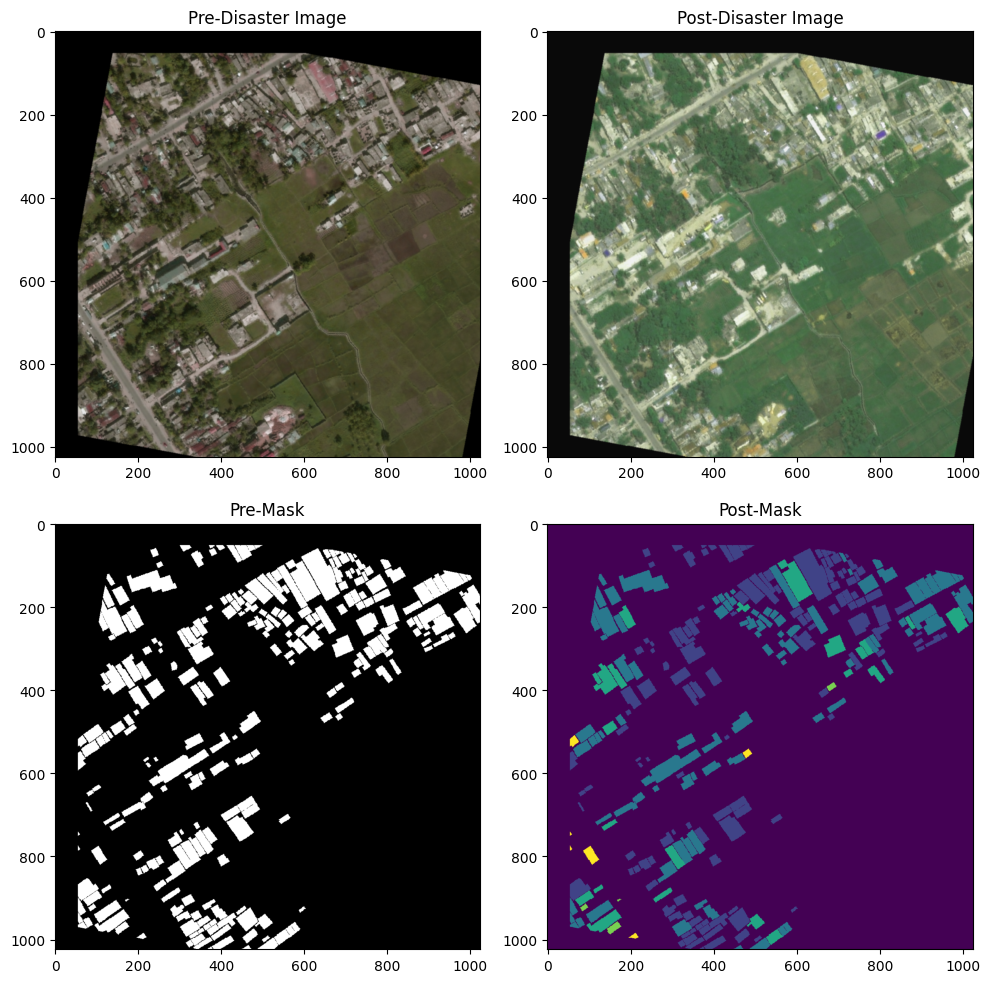

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.transforms.functional import to_pil_image

# Beispiel für das Laden des Datasets
dataset = xView2Dataset(png_path=PNG_PATH, target_path=TARGET_PATH, transform=transform(), image_transform=image_transform())

# Holen eines Beispiel-Datensatzes
sample = dataset[2]
pre_img, post_img, pre_mask, post_mask = sample

# Inverse Normalisierung
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3)  # (1,1,3) für Broadcasting
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3)

pre_img_np = pre_img.permute(1, 2, 0).numpy()  # (C, H, W) → (H, W, C)
post_img_np = post_img.permute(1, 2, 0).numpy()

# Rücktransformation: pixel = (pixel * std) + mean
pre_img_np = (pre_img_np * std.numpy()) + mean.numpy()
post_img_np = (post_img_np * std.numpy()) + mean.numpy()

# Clipping auf [0,1] für sicheres Anzeigen
pre_img_np = np.clip(pre_img_np, 0, 1)
post_img_np = np.clip(post_img_np, 0, 1)

# Umwandeln der Masken in NumPy-Arrays
pre_mask_np = pre_mask.squeeze().numpy()  # (1, H, W) → (H, W)
post_mask_np = post_mask.squeeze().numpy()

# Erstellen eines 2x2-Subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Visualisieren der Bilder
axes[0, 0].imshow(pre_img_np)
axes[0, 0].set_title("Pre-Disaster Image")
axes[0, 1].imshow(post_img_np)
axes[0, 1].set_title("Post-Disaster Image")
axes[1, 0].imshow(pre_mask_np, cmap='gray')
axes[1, 0].set_title("Pre-Mask")
axes[1, 1].imshow(post_mask_np, cmap='viridis')
axes[1, 1].set_title("Post-Mask")

# Anzeigen
plt.tight_layout()
plt.show()


In [15]:
print(pre_img)

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

# DataLoader

In [16]:
def collate_fn(batch):
      # Extrahieren der einzelnen Daten aus der Batch-Liste
    pre_imgs, post_imgs, pre_masks, post_masks = zip(*batch)

    # Stapeln der Tensoren entlang der Batch-Dimension (erste Dimension)
    pre_imgs = torch.stack(pre_imgs, dim=0)
    post_imgs = torch.stack(post_imgs, dim=0)
    pre_masks = torch.stack(pre_masks, dim=0)
    post_masks = torch.stack(post_masks, dim=0)

    return pre_imgs, post_imgs, pre_masks, post_masks

In [17]:
from torch.utils.data import DataLoader

dataloader = DataLoader(
    dataset,
    batch_size= 5, 
    collate_fn = collate_fn,
    shuffle= True,
    # TODO - Hier tritt immer ein Fehler auf wenn ich num_workers>0 und prefetch factor auswähle. wieso weiß ich nicht. 
    # num_workers=0,
    # prefetch_factor=2, # number of preloaded batches for each workre
    drop_last= True
)

In [18]:
# Beispiel, wie du durch den DataLoader iterierst
for pre_imgs, post_imgs, pre_masks, post_masks in dataloader:
    print(f"Pre-Disaster Batch Shape: {pre_imgs.shape}")
    print(f"Post-Disaster Batch Shape: {post_imgs.shape}")
    print(f"Pre-Mask Batch Shape: {pre_masks.shape}")
    print(f"Post-Mask Batch Shape: {post_masks.shape}")

Pre-Disaster Batch Shape: torch.Size([5, 3, 1024, 1024])
Post-Disaster Batch Shape: torch.Size([5, 3, 1024, 1024])
Pre-Mask Batch Shape: torch.Size([5, 1, 1024, 1024])
Post-Mask Batch Shape: torch.Size([5, 1, 1024, 1024])
Pre-Disaster Batch Shape: torch.Size([5, 3, 1024, 1024])
Post-Disaster Batch Shape: torch.Size([5, 3, 1024, 1024])
Pre-Mask Batch Shape: torch.Size([5, 1, 1024, 1024])
Post-Mask Batch Shape: torch.Size([5, 1, 1024, 1024])
Pre-Disaster Batch Shape: torch.Size([5, 3, 1024, 1024])
Post-Disaster Batch Shape: torch.Size([5, 3, 1024, 1024])
Pre-Mask Batch Shape: torch.Size([5, 1, 1024, 1024])
Post-Mask Batch Shape: torch.Size([5, 1, 1024, 1024])
Pre-Disaster Batch Shape: torch.Size([5, 3, 1024, 1024])
Post-Disaster Batch Shape: torch.Size([5, 3, 1024, 1024])
Pre-Mask Batch Shape: torch.Size([5, 1, 1024, 1024])
Post-Mask Batch Shape: torch.Size([5, 1, 1024, 1024])


# Model

## UTILS

### **Initialisierung (`__init__`Methode)**:

- **`self.loss_str`** und **`self.n_class`**: Diese Variablen speichern den Typ des Verlusts und die Anzahl der Klassen, die für die Metrik relevant sind. Wenn der `args.type` den Wert `"pre"` hat, wird davon ausgegangen, dass es nur 2 Klassen gibt (z.B. "Hintergrund" und "Objekt"). Andernfalls werden 5 Klassen verwendet.
- **`self.softmax`**: Ein Softmax-Layer wird erstellt, um Wahrscheinlichkeiten aus den Modell-Ausgaben zu berechnen.
- **`self.add_state(...)`**: Hier werden die Zustände für True Positives (TP), False Positives (FP) und False Negatives (FN) definiert. Diese Zustände werden über alle Schritte hinweg summiert, um die F1-Score-Berechnung am Ende zu ermöglichen. Sie werden mit der `dist_reduce_fx="sum"`Option über alle GPUs hinweg aggregiert, falls mehrere GPUs verwendet werden.

### 2. **Update-Methode (`update`)**:

- **`probs = self.softmax(preds)`**: Falls der Verlusttyp nicht "mse" oder "coral" ist, wird `preds` (die Modell-Ausgabe) durch Softmax normalisiert, um Wahrscheinlichkeiten zu erhalten.
    - mse = mean squared error
    - coral = correlation alignment
- **`preds = convert_to_labels(self.loss_str, probs)`**: Falls `n_class == 5` ist, werden die Vorhersagen mit einer Funktion `convert_to_labels` (die nicht im Code enthalten ist, aber vermutlich eine Umwandlung von Wahrscheinlichkeiten in Labels durchführt) in Klassenlabels umgewandelt.
- **`targets = targets[mask]` und `preds = preds[mask]`**: Falls es sich um 5 Klassen handelt, werden die Zielwerte und Vorhersagen gefiltert, um nur relevante Masken zu berücksichtigen.
- **`true_pos, false_neg, false_pos = self.get_stats(preds, targets, i + 1)`**: Für jede Klasse (außer der Hintergrundklasse) werden die Statistiken für True Positives, False Negatives und False Positives berechnet und zu den jeweiligen Zählvariablen (`tp`, `fp`, `fn`) hinzugefügt.

### 3. **Berechnung der Metrik (`compute`Methode)**:

- **`f1_score = 200 * self.tp / (2 * self.tp + self.fp + self.fn)`**: Der klassische F1-Score wird für jede Klasse berechnet.
- **`f1 = 4 / sum((f1_ + 1e-6) ** -1 for f1_ in f1_score)`**: Wenn es 5 Klassen gibt, wird der F1-Score als der harmonische Mittelwert der einzelnen F1-Scores berechnet.
- Die Methode gibt schließlich den berechneten F1-Score zurück, entweder als Vektor von F1-Scores für jede Klasse oder als aggregierten F1-Score (bei mehreren Klassen).

In [19]:

import torch
import torchmetrics
import torch.nn as nn
import torch.nn.functional as F
# from pytorch_lightning.metrics import Metric
from torchmetrics import Metric


def convert_to_labels(loss_str, logits):
    if loss_str == "mse":
        preds = torch.round(F.relu(logits[:, 0], inplace=True)) + 1
        preds[preds > 4] = 4
    elif loss_str == "coral":
        preds = torch.sum(torch.sigmoid(logits) > 0.5, dim=1) + 1
    else:
        preds = torch.argmax(logits, dim=1) + 1
    return preds


class F1(Metric):
    def __init__(self, args):
        super().__init__(dist_sync_on_step=False)
        self.loss_str = args.loss_str
        self.n_class = 2 if args.type == "pre" else 5
        self.softmax = nn.Softmax(dim=1)
        self.add_state("tp", default=torch.zeros((self.n_class - 1,)), dist_reduce_fx="sum")
        self.add_state("fp", default=torch.zeros((self.n_class - 1,)), dist_reduce_fx="sum")
        self.add_state("fn", default=torch.zeros((self.n_class - 1,)), dist_reduce_fx="sum")

    def update(self, preds, targets):
        probs = self.softmax(preds) if self.loss_str not in ["mse", "coral"] else preds
        if self.n_class == 5:
            preds = convert_to_labels(self.loss_str, probs)
            mask = targets > 0
            targets = targets[mask]
            preds = preds[mask]
        else:
            preds = torch.argmax(probs, dim=1)

        for i in range(self.n_class - 1):
            true_pos, false_neg, false_pos = self.get_stats(preds, targets, i + 1)
            self.tp[i] += true_pos
            self.fn[i] += false_neg
            self.fp[i] += false_pos

    def compute(self):
        f1_score = 200 * self.tp / (2 * self.tp + self.fp + self.fn)
        if self.n_class == 5:
            f1 = 4 / sum((f1_ + 1e-6) ** -1 for f1_ in f1_score)
            return f1.cpu(), f1_score.cpu()
        return f1_score.cpu(), None

    @staticmethod
    def get_stats(pred, targ, class_idx):
        true_pos = torch.logical_and(pred == class_idx, targ == class_idx).sum()
        false_neg = torch.logical_and(pred != class_idx, targ == class_idx).sum()
        false_pos = torch.logical_and(pred == class_idx, targ != class_idx).sum()
        return true_pos, false_neg, false_pos

In [20]:
# Adapted from https://github.com/chemprop/chemprop/blob/master/chemprop/nn_utils.py
import numpy as np
from torch.optim.lr_scheduler import _LRScheduler


class NoamLR(_LRScheduler):
    def __init__(
        self,
        optimizer,
        warmup_epochs,
        total_epochs,
        steps_per_epoch,
        init_lr,
        max_lr,
        final_lr,
        fine_tune_coff=1.0,
        fine_tune_param_idx=0,
    ):

        self.num_lrs = len(optimizer.param_groups)

        self.optimizer = optimizer
        self.warmup_epochs = np.array([warmup_epochs] * self.num_lrs)
        self.total_epochs = np.array([total_epochs] * self.num_lrs)
        self.steps_per_epoch = steps_per_epoch
        self.init_lr = np.array([init_lr] * self.num_lrs)
        self.max_lr = np.array([max_lr] * self.num_lrs)
        self.final_lr = np.array([final_lr] * self.num_lrs)
        self.lr_coff = np.array([1] * self.num_lrs)
        self.fine_tune_param_idx = fine_tune_param_idx
        self.lr_coff[self.fine_tune_param_idx] = fine_tune_coff

        self.current_step = 0
        self.lr = [init_lr] * self.num_lrs
        self.warmup_steps = (self.warmup_epochs * self.steps_per_epoch).astype(int)
        self.total_steps = self.total_epochs * self.steps_per_epoch
        self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps

        self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))
        super(NoamLR, self).__init__(optimizer)

    def get_lr(self):
        return list(self.lr)

    def step(self, current_step=None):

        if current_step is not None:
            self.current_step = current_step
        else:
            self.current_step += 1
        for i in range(self.num_lrs):
            if self.current_step <= self.warmup_steps[i]:
                self.lr[i] = self.init_lr[i] + self.current_step * self.linear_increment[i]
            elif self.current_step <= self.total_steps[i]:
                self.lr[i] = self.max_lr[i] * (self.exponential_gamma[i] ** (self.current_step - self.warmup_steps[i]))
            else:
                self.lr[i] = self.final_lr[i]
            self.lr[i] *= self.lr_coff[i]
            self.optimizer.param_groups[i]["lr"] = self.lr[i]

## Layers

In [21]:
import torch
import torch.nn.functional as F
from torch import nn


class PPM(nn.Module):
    def __init__(self, in_channels):
        super(PPM, self).__init__()
        self.features = []
        out_channels = in_channels // 4
        for bin in (1, 2, 3, 6):
            self.features.append(
                nn.Sequential(
                    nn.AdaptiveAvgPool2d(bin),
                    nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                    nn.BatchNorm2d(out_channels, affine=True),
                    nn.LeakyReLU(negative_slope=0.01, inplace=True),
                )
            )
        self.features = nn.ModuleList(self.features)
        self.conv = nn.Conv2d(2 * in_channels, in_channels, kernel_size=1, bias=True)

    def forward(self, x):
        x_size = x.size()
        out = [x]
        for f in self.features:
            out.append(F.interpolate(f(x), x_size[2:], mode="bilinear", align_corners=True))
        out = self.conv(torch.cat(out, 1))
        return out


class ASPPModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, dilation):
        super(ASPPModule, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_channels, affine=True)
        self.relu = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        self._init_weight()

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)


class ASPP(nn.Module):
    def __init__(self, in_channels, dilation):
        super(ASPP, self).__init__()
        out_channels = in_channels // 4
        dilations = [1, 3 * dilation, 6 * dilation, 9 * dilation]
        self.aspp1 = ASPPModule(in_channels, out_channels, 1, padding=0, dilation=dilations[0])
        self.aspp2 = ASPPModule(in_channels, out_channels, 3, padding=dilations[1], dilation=dilations[1])
        self.aspp3 = ASPPModule(in_channels, out_channels, 3, padding=dilations[2], dilation=dilations[2])
        self.aspp4 = ASPPModule(in_channels, out_channels, 3, padding=dilations[3], dilation=dilations[3])

    def forward(self, x):
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        out = torch.cat((x1, x2, x3, x4), dim=1)
        return out


class AttentionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AttentionLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels, affine=True)

    def forward(self, inputs):
        out = self.conv(inputs)
        out = self.batch_norm(out)
        return out


class ConvTranspose(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvTranspose, self).__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, bias=False)

    def forward(self, inputs):
        return self.conv(inputs)


class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels, affine=True)
        self.lrelu = nn.LeakyReLU(negative_slope=0.01, inplace=True)

    def forward(self, inputs):
        out = self.conv(inputs)
        out = self.batch_norm(out)
        out = self.lrelu(out)
        return out


class FusionBlock(nn.Module):
    def __init__(self, pre_conv, post_conv, channels):
        super(FusionBlock, self).__init__()
        self.pre_conv = pre_conv
        self.post_conv = post_conv
        self.conv_pre = ConvLayer(2 * channels, channels)
        self.conv_post = ConvLayer(2 * channels, channels)

    def forward(self, pre, post, dec_pre=None, dec_post=None, last_dec=False):
        pre = self.pre_conv(pre, dec_pre) if dec_pre is not None or last_dec else self.pre_conv(pre)
        post = self.post_conv(post, dec_post) if dec_post is not None or last_dec else self.post_conv(post)
        fmap = torch.cat([pre, post], 1)
        pre, post = self.conv_pre(fmap), self.conv_post(fmap)
        return pre, post


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = ConvLayer(in_channels, out_channels)
        self.conv2 = ConvLayer(out_channels, out_channels)

    def forward(self, inputs):
        out = self.conv1(inputs)
        out = self.conv2(out)
        return out

class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, skip_channels, attention, dec_interp):
        super(UpsampleBlock, self).__init__()
        self.attention = attention
        self.dec_interp = dec_interp
        self.skip_channels = skip_channels
        inc = skip_channels + out_channels
        if self.dec_interp:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=True)
        else:
            self.conv_tranpose = ConvTranspose(in_channels, out_channels)

        self.conv_block = ConvBlock(inc, out_channels)
        if skip_channels > 0 and self.attention:
            att_out = out_channels // 2
            self.conv_o = AttentionLayer(out_channels, att_out)
            self.conv_s = AttentionLayer(skip_channels, att_out)
            self.psi = AttentionLayer(att_out, 1)
            self.sigmoid = nn.Sigmoid()
            self.relu = nn.ReLU(inplace=True)

    def forward(self, inputs, skip):
        if self.dec_interp:
            out = F.interpolate(self.conv(inputs), scale_factor=2, mode="bilinear", align_corners=True)
        else:
            out = self.conv_tranpose(inputs)

        if self.skip_channels == 0:
            return self.conv_block(out)

        if self.attention:
            out_a = self.conv_o(out)
            skip_a = self.conv_s(skip)
            psi_a = self.psi(self.relu(out_a + skip_a))
            attention = self.sigmoid(psi_a)
            skip = skip * attention
        out = self.conv_block(torch.cat((out, skip), dim=1))
        return out
    
    
class OutputBlock(nn.Module):
    def __init__(self, in_channels, nclass, interpolate):
        super(OutputBlock, self).__init__()
        self.interpolate = interpolate
        self.coral_loss = nclass == 3
        if self.coral_loss:
            self.conv = nn.Conv2d(in_channels, 1, kernel_size=1, bias=False)
            self.bias = nn.Parameter(torch.tensor([[[1.0]], [[0.0]], [[-1.0]]]))
        else:
            self.conv = nn.Conv2d(in_channels, nclass, kernel_size=1)

    def forward(self, inputs):
        out = self.conv(inputs)
        if self.coral_loss:
            out = out + self.bias
        if self.interpolate:
            size = (512, 512) if self.training else (1024, 1024)
            out = F.interpolate(out, size, mode="bilinear", align_corners=True)
        return out



## UNET

In [22]:
import torch
import torch.nn.functional as F
import torchvision.models as models
from resnest.torch import resnest50, resnest101, resnest200, resnest269
from torch import nn

#from model.layers import ASPP, PPM, FusionBlock, OutputBlock, UpsampleBlock




resnest = {
    "resnest50": resnest50,
    "resnest101": resnest101,
    "resnest200": resnest200,
    "resnest269": resnest269,
}


def concat(x: Optional[torch.Tensor],
           y: Optional[torch.Tensor] ) -> Optional[torch.Tensor]:
    return None if x is None or y is None else torch.cat([x, y], 1)


def get_nclass(args) -> int:
    if args.loss_str == "mse":
        return 1
    elif args.loss_str == "coral":
        return 3
    return 4



'''def get_dmg_unet(args):
    dmg_unets = {
        "siamese": SiameseUNet,
     }
    nclass = get_nclass(args)
    model = dmg_unets[args.dmg_model](args, nclass)
    return model'''



def get_encoder(encoder_str:str ,
                dilation: int ,
                pretrained: bool = True,
                in_channels: int = 3)  -> Tuple[List[int], nn.Module, nn.Module, nn.Module, nn.Module, nn.Module]:
    assert "resnet" in encoder_str or "resnest" in encoder_str

    if "resnest" in encoder_str:
        encoder_channels = [128, 256, 512, 1024, 2048]
        if "50" in encoder_str:
            encoder_channels[0] = 64
        encoder = resnest[encoder_str](pretrained=pretrained, dilation=dilation)
    else:
        encoder_channels = [64, 256, 512, 1024, 2048]
        replace_stride_with_dilation = [False, dilation == 4, dilation in [2, 4]]
        if encoder_str == "resnet50":
            encoder = models.resnet50(pretrained=pretrained, replace_stride_with_dilation=replace_stride_with_dilation)
        elif encoder_str == "resnet101":
            encoder = models.resnet101(pretrained=pretrained, replace_stride_with_dilation=replace_stride_with_dilation)
        elif encoder_str == "resnet152":
            encoder = models.resnet152(pretrained=pretrained, replace_stride_with_dilation=replace_stride_with_dilation)
        else:
            raise f"Not implemented encoder {encoder_str}"

    if in_channels != 3:
        conv1 = encoder.conv1[0] if "st" in encoder else encoder.conv1
        conv1 = torch.nn.Conv2d(
            in_channels,
            conv1.out_channels,
            kernel_size=conv1.kernel_size,
            stride=conv1.stride,
            padding=conv1.padding,
            bias=conv1.bias,
        )
        if "st" in encoder:
            encoder.conv1[0] = conv1
        else:
            encoder.conv1 = conv1

    encoder_layer1 = nn.Sequential(encoder.conv1, encoder.bn1, nn.ReLU(inplace=True))
    encoder_layer2 = nn.Sequential(encoder.maxpool, encoder.layer1)
    encoder_layer3 = encoder.layer2
    encoder_layer4 = encoder.layer3
    encoder_layer5 = encoder.layer4

    return encoder_channels, encoder_layer1, encoder_layer2, encoder_layer3, encoder_layer4, encoder_layer5


def get_decoder(encf: List[int], # List von Ints, die die Kanäle der Encoder Schichten repräsentiert
                dilation: int, # Dilation Faktor
                attn: bool, # Attention Mechanism 
                no_skip: bool = False, 
                dec_interp: bool = False):
    
    decf = [512, 256, 128, 64, 32]
    if dilation == 1:
        decoder_layer1 = UpsampleBlock(encf[-1], decf[0], 0 if no_skip else encf[-2], attn, dec_interp)
        decoder_layer2 = UpsampleBlock(decf[0], decf[1], 0 if no_skip else encf[-3], attn, dec_interp)
        decoder_layer3 = UpsampleBlock(decf[1], decf[2], 0 if no_skip else encf[-4], attn, dec_interp)
        decoder_layer4 = UpsampleBlock(decf[2], decf[3], 0 if no_skip else encf[-5], attn, dec_interp)
        decoder_layer5 = UpsampleBlock(decf[3], decf[4], 0, attn, dec_interp)
    elif dilation == 2:
        decoder_layer1 = None
        decoder_layer2 = UpsampleBlock(encf[-1], decf[1], 0 if no_skip else encf[-3], attn, dec_interp)
        decoder_layer3 = UpsampleBlock(decf[1], decf[2], 0 if no_skip else encf[-4], attn, dec_interp)
        decoder_layer4 = UpsampleBlock(decf[2], decf[3], 0 if no_skip else encf[-5], attn, dec_interp)
        decoder_layer5 = UpsampleBlock(decf[3], decf[4], 0, attn, dec_interp)
    elif dilation == 4:
        decoder_layer1, decoder_layer2 = None, None
        decoder_layer3 = UpsampleBlock(encf[-1], decf[2], 0 if no_skip else encf[-4], attn, dec_interp)
        decoder_layer4 = UpsampleBlock(decf[2], decf[3], 0 if no_skip else encf[-5], attn, dec_interp)
        decoder_layer5 = UpsampleBlock(decf[3], decf[4], 0, attn, dec_interp)
    else:
        raise ValueError("Dilation can be set to 1, 2 or 4")
    return decf, decoder_layer1, decoder_layer2, decoder_layer3, decoder_layer4, decoder_layer5


# En- und Decoder der für die Bilder genutzt wird

class UNetTemplate(nn.Module):
    def __init__(self, args, in_channels=3):
        super(UNetTemplate, self).__init__()
        self.use_ppm = args.ppm
        self.use_aspp = args.aspp
        self.dilation = args.dilation
        self.no_skip = args.no_skip
        self.interpolate = args.interpolate
        self.enc_chn, self.enc_l1, self.enc_l2, self.enc_l3, self.enc_l4, self.enc_l5 = get_encoder(
            args.encoder, self.dilation, in_channels=in_channels
        )

        if self.use_ppm:
            self.ppm = PPM(self.enc_chn[-1])
        elif self.use_aspp:
            self.aspp = ASPP(self.enc_chn[-1], self.dilation)

        self.dec_chn = None
        if not self.interpolate:
            self.dec_chn, self.dec_l1, self.dec_l2, self.dec_l3, self.dec_l4, self.dec_l5 = get_decoder(
                self.enc_chn, self.dilation, args.attention, self.no_skip, args.dec_interp
            )

    def forward(self, data):
        enc1 = self.enc_l1(data)
        enc2 = self.enc_l2(enc1)
        enc3 = self.enc_l3(enc2)
        enc4 = self.enc_l4(enc3)
        enc5 = self.enc_l5(enc4)

        if self.use_ppm:
            enc5 = self.ppm(enc5)
        elif self.use_aspp:
            enc5 = self.aspp(enc5)
        if self.interpolate:
            return enc5, None, None

        if self.dilation == 1:
            if self.no_skip:
                enc1, enc2, enc3, enc4 = None, None, None, None
            dec1 = self.dec_l1(enc5, enc4)
            dec2 = self.dec_l2(dec1, enc3)
            dec3 = self.dec_l3(dec2, enc2)
            dec4 = self.dec_l4(dec3, enc1)
            dec5 = self.dec_l5(dec4, None)
        elif self.dilation == 2:
            if self.no_skip:
                enc1, enc2, enc3 = None, None, None
            dec2 = self.dec_l2(enc5, enc3)
            dec3 = self.dec_l3(dec2, enc2)
            dec4 = self.dec_l4(dec3, enc1)
            dec5 = self.dec_l5(dec4, None)
        elif self.dilation == 4:
            if self.no_skip:
                enc1, enc2 = None, None
            dec3 = self.dec_l3(enc5, enc2)
            dec4 = self.dec_l4(dec3, enc1)
            dec5 = self.dec_l5(dec4, None)

        return dec5, dec4, dec3

# bekommt die Decoder Outputs als Eingabe - besteht aus einer Output-Blick Schicht, die die Schadensklasse für jedes Pixel vorhersagt

class OutputTemplate(nn.Module):
    def __init__(self, 
                 n_class: int, 
                 deep_supervision: bool, # Sollen beim Training Zwischen Schichten überwacht werden
                 dec_chn: List[int], # Liste von Ints, die die Kanäle der Decoder-Schichten des Modells repräsentiert
                 scale: int = 1, 
                 interp: bool = False, # interpolation der Ausgabe
                 enc_last:int = 0): # Anzahl der Kanäle für die letzte Encoder schicht
        
        super(OutputTemplate, self).__init__()
        self.deep_supervision = deep_supervision
        self.interp = interp
        if self.interp:
            d5 = enc_last * scale
            self.deep_supervision = False
        else:
            d3, d4, d5 = scale * dec_chn[-3], scale * dec_chn[-2], scale * dec_chn[-1]

        if self.deep_supervision:
            self.output_block_ds3 = OutputBlock(d3, n_class, interp)
            self.output_block_ds4 = OutputBlock(d4, n_class, interp)
        self.output_block = OutputBlock(d5, n_class, interp)

    def forward(self, dec5, dec4, dec3):
        out = self.output_block(dec5)
        if self.training and self.deep_supervision:
            out_dec3 = self.output_block_ds3(dec3)
            out_dec4 = self.output_block_ds4(dec4)
            return [out, out_dec4, out_dec3]
        return out


# Aufbau: 
#
#  2 UNet Encoder (Siehe UnetTemplate) die jeweils pre und post disaster bilder verarbeiten
# Kombiniert die Envoder outputs durch Konkartenation 
# Gibt Feature Maps an ein OutputTemplate weiter




class SiameseUNet(nn.Module):
    def __init__(self, args, n_class: int):
        super(SiameseUNet, self).__init__()
        self.unet = UNetTemplate(args) 
        self.output_block = OutputTemplate(
            n_class,
            args.deep_supervision,
            self.unet.dec_chn,
            2,
            args.interpolate,
            self.unet.enc_chn[-1],
        )

    def forward(self, data):
        pre_dec5, pre_dec4, pre_dec3 = self.unet(data[:, :3]) # da UNet5 Stufen hat - startet decoder bei 5 
        post_dec5, post_dec4, post_dec3 = self.unet(data[:, 3:])
        dec5, dec4, dec3 = concat(pre_dec5, post_dec5), concat(pre_dec4, post_dec4), concat(pre_dec3, post_dec3)
        out = self.output_block(dec5, dec4, dec3)
        return out

**Forwards-Pass** Modell bekommt als Eingabe ein Tensor data mit 6 Kanälen (je 3 pro Image (pre+post))


## LOSS


-> Coral Loss besonders gut zur Schadesnbewertung geeignet 
-> Cross Entropy Loss: eine der am häufigsten genutzten Loss functions

In [23]:

class CORAL(nn.Module):
    # Adapted to image segmentation based on https://github.com/Raschka-research-group/coral-cnn
    def __init__(self):
        super(CORAL, self).__init__()
        self.levels = torch.tensor([[0, 0, 0], [1, 0, 0], [1, 1, 0], [1, 1, 1]], dtype=torch.float32)

    def forward(self, y_pred, y_true):
        device = y_pred.device
        levels = self.levels[y_true].to(device)
        logpt = F.logsigmoid(y_pred)
        loss = torch.sum(logpt * levels + (logpt - y_pred) * (1 - levels), dim=1)
        return -torch.mean(loss)




losses = {
    "ce": nn.CrossEntropyLoss(),
    "coral": CORAL(),
}


class Loss(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.loss_str = args.loss_str
        self.post = args.type == "post"
        self.losses = nn.ModuleList([losses[loss_fn] for loss_fn in self.loss_str.split("+")])

    def forward(self, y_pred, y_true):
        if self.post:
            device = y_pred.device
            mask = y_true > 0
            y_pred = torch.stack([y_pred[:, i][mask] for i in range(y_pred.shape[1])], 1).to(device)
            y_true = y_true[mask] - 1

        if self.loss_str == "mse":
            y_pred = F.relu(y_pred[:, 0], inplace=True)
            y_true = y_true.float()
        else:
            y_true = y_true.long()

        loss = 0
        for loss_fn in self.losses:
            loss += loss_fn(y_pred, y_true)
        return loss

## PLT

### Lightnig Module:
- Lightning Module organized PyTorch Code into 6 sections:
1. Computations (init)
2. Training loop (training_step)
3. Validation Loop (validation_step)
4. Test Loop (test_step)
5. Prediction Loop (predict_step)
6. Optimizers and LR Scheduler (configure_optimizers)


### ***forward()***
Test Time Augmentation (TTA):

if self.args.tta: Wenn die TTA aktiviert ist, wird das Modell zusätzlich auf verschiedenen Versionen des Bildes getestet, die durch Drehung oder Spiegelung verändert wurden.
for flip_idx in self.tta_flips: Hier wird für jedes Flip (in self.tta_flips definiert) das Bild gespiegelt und dann die Vorhersage für das gespiegelte Bild berechnet.
pred += self.flip(self.model(self.flip(img, flip_idx)), flip_idx): Für jedes gespiegelte Bild wird die Vorhersage (nach der Spiegelung) zum bisherigen Ergebnis addiert.
pred /= len(self.tta_flips) + 1: Die Vorhersagen werden durch die Anzahl der durchgeführten TTA-Varianten geteilt, um eine Durchschnittsvorhersage zu erhalten.
return pred: Gibt die finale Vorhersage zurück, die nach der TTA möglicherweise angepasst wurde.

In [24]:
import os
from argparse import ArgumentParser

import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
#from apex.optimizers import FusedAdam, FusedNovoGrad, FusedSGD
# from dllogger import JSONStreamBackend, Logger, StdOutBackend, Verbosity
from PIL import Image
#from torch_optimizer import AdaBelief, AdaBound, AdamP, RAdam


# vor definierte funktionen
# from utils.f1 import F1
# from utils.scheduler import NoamLR

In [25]:
class Model (pl.LightningModule):
    def __init__(self, args): # args = Argument Container(Object oder Dict) enthält alle hyperparameter
        super(Model, self).__init__() # aufrufen des Konstruktor der LightningClass
        self.save_hyperparameters() 
        self.args = args
        self.f1_score = F1(args)
        self.model = SiameseUNet(args, get_nclass(args))
        self.loss = Loss(args)
        self.best_f1 = torch.tensor(0)
        self.best_epoch = 0
        self.tta_flips = [[2], [3], [2, 3]]
        self.lr = args.lr
        # self.n_class = 2 if self.args.type == "pre" else 5
        self.n_class = 5
        self.softmax = nn.Softmax(dim=1)
        self.test_idx = 0 
        
        # self.dllogger = Logger(
        #     backends=[
        #         JSONStreamBackend(Verbosity.VERBOSE, os.path.join(args.results, f"{args.logname}.json")),
        #         StdOutBackend(Verbosity.VERBOSE, step_format=lambda step: f"Epoch: {step} "),
        #     ]
        # )


    def forward(self, img):
        pred = self.model(img)
        if self.args.tta: # tta = Test Time Augmentation 
            for flip_idx in self.tta_flips:
                pred += self.flip(self.model(self.flip(img, flip_idx)), flip_idx)
            pred /= len(self.tta_flips) + 1
        return pred

# TODO- Die Namen für image und mask müssen angepasst werden!!!!

    def training_step(self, batch, _):
        img, lbl = batch["image"], batch["mask"] 
        pred = self.model(img)
        loss = self.compute_loss(pred, lbl)
        return loss

    def validation_step(self, batch, _):
        img, lbl = batch["image"], batch["mask"]
        pred = self.forward(img)
        loss = self.loss(pred, lbl)
        self.f1_score.update(pred, lbl)
        return {"val_loss": loss}

    def test_step(self, batch, batch_idx):
        img, lbl = batch["image"], batch["mask"]
        pred = self.forward(img)
        self.f1_score.update(pred, lbl)
        self.save(pred, lbl)

    def compute_loss(self, preds, label):
        if self.args.deep_supervision:
            loss = self.loss(preds[0], label)
            for i, pred in enumerate(preds[1:]):
                downsampled_label = torch.nn.functional.interpolate(label.unsqueeze(1), pred.shape[2:])
                loss += 0.5 ** (i + 1) * self.loss(pred, downsampled_label.squeeze(1))
            c_norm = 1 / (2 - 2 ** (-len(preds)))
            return c_norm * loss
        return self.loss(preds, label)

    @staticmethod
    def metric_mean(name, outputs): 
        return torch.stack([out[name] for out in outputs]).mean(dim=0)

    @staticmethod
    def update_damage_scores(metrics, dmgs_f1):
        if dmgs_f1 is not None:
            for i in range(4):
                metrics.update({f"D{i+1}": round(dmgs_f1[i].item(), 3)})

    def on_validation_epoch_start(self):
        self.f1_score.reset()

    def on_test_epoch_start(self):
        self.f1_score.reset()

    def validation_epoch_end(self, outputs):
        loss = self.metric_mean("val_loss", outputs)
        f1_score, dmgs_f1 = self.f1_score.compute()
        self.f1_score.reset()

        if f1_score >= self.best_f1:
            self.best_f1 = f1_score
            self.best_epoch = self.current_epoch

        if int(os.getenv("LOCAL_RANK", "0")) == 0:
            metrics = {
                "f1": round(f1_score.item(), 3),
                "val_loss": round(loss.item(), 3),
                "top_f1": round(self.best_f1.item(), 3),
            }
            self.update_damage_scores(metrics, dmgs_f1)
            # self.dllogger.log(step=self.current_epoch, data=metrics)
            # self.dllogger.flush()

        self.log("f1_score", f1_score.cpu())
        self.log("val_loss", loss.cpu())

    def test_epoch_end(self, _):
        f1_score, dmgs_f1 = self.f1_score.compute()
        self.f1_score.reset()
        if int(os.getenv("LOCAL_RANK", "0")) == 0:
            metrics = {"f1": round(f1_score.item(), 3)}
            self.update_damage_scores(metrics, dmgs_f1)
            # self.dllogger.log(step=(), data=metrics)
            # self.dllogger.flush()

    def save(self, preds, targets):
        if self.args.type == "pre":
            probs = torch.sigmoid(preds[:, 1])
        else:
            if self.args.loss_str == "coral":
                probs = torch.sum(torch.sigmoid(preds) > 0.5, dim=1) + 1
            elif self.args.loss_str == "mse":
                probs = torch.round(F.relu(preds[:, 0], inplace=True)) + 1
            else:
                probs = self.softmax(preds)

        probs = probs.cpu().detach().numpy()
        targets = targets.cpu().detach().numpy().astype(np.uint8)
        for prob, target in zip(probs, targets):
            task = "damage"
            fname = os.path.join(self.args.results, "probs", f"test_{task}_{self.test_idx:05d}")
            self.test_idx += 1
            np.save(fname, prob)
            Image.fromarray(target).save(fname.replace("probs", "targets") + "_target.png")

    @staticmethod
    def flip(data, axis):
        return torch.flip(data, dims=axis)

    def configure_optimizers(self):
        optimizer = {
            "sgd": torch.optim.SGD(self.parameters(), lr=self.lr, momentum=self.args.momentum),
            "adam": torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.args.weight_decay),
            "novograd": torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.args.weight_decay),
            # "sgd": FusedSGD(self.parameters(), lr=self.lr, momentum=self.args.momentum),
            # "adam": FusedAdam(self.parameters(), lr=self.lr, weight_decay=self.args.weight_decay),
            "adamw": torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.args.weight_decay),
            # "radam": RAdam(self.parameters(), lr=self.lr, weight_decay=self.args.weight_decay),
            # "adabelief": AdaBelief(self.parameters(), lr=self.lr, weight_decay=self.args.weight_decay),
            # "adabound": AdaBound(self.parameters(), lr=self.lr, weight_decay=self.args.weight_decay),
            # "adamp": AdamP(self.parameters(), lr=self.lr, weight_decay=self.args.weight_decay),
            # "novograd": FusedNovoGrad(self.parameters(), lr=self.lr, weight_decay=self.args.weight_decay),
        }[self.args.optimizer.lower()]

        if not self.args.use_scheduler:
            return optimizer

        scheduler = {
            "scheduler": NoamLR(
                optimizer=optimizer,
                warmup_epochs=self.args.warmup,
                total_epochs=self.args.epochs,
                steps_per_epoch=len(self.train_dataloader()) // self.args.gpus,
                init_lr=self.args.init_lr,
                max_lr=self.args.lr,
                final_lr=self.args.final_lr,
            ),
            "interval": "step",
            "frequency": 1,
        }

        return {"optimizer": optimizer, "lr_scheduler": scheduler}

    @staticmethod
    def add_model_specific_args(parent_parser):
        parser = ArgumentParser(parents=[parent_parser], add_help=False)
        arg = parser.add_argument

        # optimizer-arguemnts
        arg(
            "--optimizer",
            type=str,
            default="adamw",
            choices=["sgd", "adam", "adamw", "novograd"],
        )
        # model arguemnte sind hinfällig, da nur siamese genutzt wird.
        # arg(
        #     "--dmg_model",
        #     type=str,
        #     default="siamese",
        #     choices=["siamese", "siameseEnc", "fused", "fusedEnc", "parallel", "parallelEnc", "diff", "cat"],
        #     help="U-Net variant for damage assessment task",
        # )
        arg(
            "--encoder",
            type=str,
            default="resnest200",
            choices=["resnest50", "resnest101", "resnest200", "resnest269", "resnet50", "resnet101", "resnet152"],
            help="U-Net encoder",
        )
        arg(
            "--loss_str",
            type=str,
            default="focal+dice",
            help="Combination of: dice, focal, ce, ohem, mse, coral, e.Fg focal+dice creates the loss function as sum of focal and dice",
        )
        arg("--use_scheduler", action="store_true", help="Enable Noam learning rate scheduler") 
        arg("--warmup", type=int, default=1, help="Warmup epochs for Noam learning rate scheduler")
        arg("--init_lr", type=float, default=1e-4, help="Initial learning rate for Noam scheduler")
        arg("--final_lr", type=float, default=1e-4, help="Final learning rate for Noam scheduler")
        arg("--lr", type=float, default=3e-4, help="Learning rate, or a target learning rate for Noam scheduler")
        arg("--weight_decay", type=float, default=0, help="Weight decay (L2 penalty)")
        arg("--momentum", type=float, default=0.9, help="Momentum for SGD optimizer")
        arg(
            "--dilation",
            type=int,
            choices=[1, 2, 4],
            default=1,
            help="Dilation rate for a encoder, e.g dilation=2 uses dilation instead of stride in the last encoder block",
        )
        arg("--tta", action="store_true", help="Enable test time augmentation")
        arg("--ppm", action="store_true", help="Use pyramid pooling module")
        arg("--aspp", action="store_true", help="Use atrous spatial pyramid pooling")
        arg("--no_skip", action="store_true", help="Disable skip connections in UNet")
        arg("--deep_supervision", action="store_true", help="Enable deep supervision")
        arg("--attention", action="store_true", help="Enable attention module at the decoder")
        arg("--autoaugment", action="store_true", help="Use imageNet autoaugment pipeline")
        arg("--interpolate", action="store_true", help="Interpolate feature map from encoder without a decoder")
        arg("--dec_interp", action="store_true", help="Use interpolation instead of transposed convolution in a decoder")
        return parser
        

| Argument            | Bedeutung                                          |
|---------------------|----------------------------------------------------|
| `--optimizer`        | Wählt den Optimizer (z. B. "adamw")               |
| `--weight_decay`     | Fügt L2-Regularisierung hinzu                    |
| `--momentum`         | Momentum für SGD                                  |
| `--use_scheduler`    | Aktiviert Noam-Scheduler                         |
| `--warmup`           | Anzahl der Warmup-Epochen                        |
| `--init_lr`          | Start-Learning-Rate                               |
| `--final_lr`         | End-Learning-Rate                                 |
| `--lr`               | Feste Learning Rate, falls kein Scheduler         |
| `--encoder`          | Wählt das Encoder-Backbone                        |
| `--loss_str`         | Loss-Funktion (z. B. "focal+dice")                |
| `--dilation`         | Dilationsrate für den Encoder                    |
| `--no_skip`          | Deaktiviert Skip-Connections                      |
| `--deep_supervision` | Fügt zusätzliche Loss-Funktion hinzu              |
| `--attention`        | Aktiviert Attention-Modul                         |
| `--tta`              | Aktiviert Test-Time Augmentation                  |
| `--autoaugment`      | Aktiviert Autoaugment-Pipeline                    |
| `--ppm`              | Aktiviert Pyramid Pooling                         |
| `--aspp`             | Aktiviert Atrous Spatial Pyramid Pooling          |
| `--interpolate`      | Interpoliert die Feature Map statt Decoder        |
| `--dec_interp`       | Verwendet Interpolation statt Transposed Conv     |


# Trainings-Setup

AttributeError: 'Namespace' object has no attribute 'ppm'